# Customer Segmentation Using RFM Analysis (Quantiles Method and K-Means Clustering

Here are the key steps that i took in this Clustering Projects :

**1. Data Preparation**
    - Creating Recency DataFrames
    - Creating Frequency DataFrames
    - Creating Monetary DataFrames
    - Creating RFM DataFrames
**2. RFM Analysis with Quantiles Method**
    - Calculate RFM Quantiles
    - Creating Segments using Quantiles
    - Create RFM Segmentation Table
    - Calculate RFMScore and Generate Clusters
**3. RFM Analysis Using K-Means Clustering**
    - Define K Value for clustering
    - Fitting Model Predicting CLuster
    - Cluster Visualization
    - Cluster Evaluation
**4. Cluster Exploration**
    - How many Customer for each group/cluster?
    - How does each cluster/group contribute to the company's revenue?
    - What is the common stock ordered in each group
    - When does each cluster usually made an order?
    - How does each cluster react on a discounts?



## Section 01 :  Data Preparation

In this section, i am going to prepare an RFM datasets that is ready for analysis either using Quantiles Method or using K-Means Clustering. To give a comprehensive understanding of this project, here are some explanation of each calculation:
1. Recency : last date available in Dataset - last date of purchase each customer
2. Frequency : calculate frequency of purchases, count each particular InvoiceNo 
3. Monetary : Quantity * UnitPrice

Now, let's try to code and get the RFM Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("E-commerce_data_clean.csv")
data.head()

,InvoiceNo,InvoiceDate,Date,Years,Months,Days,Hours,DayOfMonth,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalCost
0,536365,2010-12-01 08:26:00,2010-12-01,2010,12,3,8,1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30
1,536366,2010-12-01 08:28:00,2010-12-01,2010,12,3,8,1,22633,HAND WARMER UNION JACK,6,1.85,17850,United Kingdom,11.10
2,536367,2010-12-01 08:34:00,2010-12-01,2010,12,3,8,1,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1.69,13047,United Kingdom,54.08
3,536368,2010-12-01 08:34:00,2010-12-01,2010,12,3,8,1,22960,JAM MAKING SET WITH JARS,6,4.25,13047,United Kingdom,25.50
4,536369,2010-12-01 08:35:00,2010-12-01,2010,12,3,8,1,21756,BATH BUILDING BLOCK WORD,3,5.95,13047,United Kingdom,17.85


### 1. Create Recency Data Frame

In [3]:
#group by customers and check last date of purshace
recency_df = data.groupby(by='CustomerID', as_index=False)['Date'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346,2011-01-18
1,12347,2011-12-07
2,12348,2011-09-25
3,12349,2011-11-21
4,12350,2011-02-02


In [4]:
now = data['Date'].max()
now = pd.to_datetime(now)
recency_df['LastPurchaseDate'] = pd.to_datetime(recency_df['LastPurchaseDate'])

In [5]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now - x).days)
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346,2011-01-18,325
1,12347,2011-12-07,2
2,12348,2011-09-25,75
3,12349,2011-11-21,18
4,12350,2011-02-02,310


In [6]:
recency_df['LastPurchaseDate'].apply(lambda x: (now - x).days)

0       325
1         2
2        75
3        18
4       310
       ... 
4367    277
4368    180
4369      7
4370      3
4371     42
Name: LastPurchaseDate, Length: 4372, dtype: int64

In [7]:
# Drop LastPurchaseDate because we don't need it
recency_df = recency_df.drop('LastPurchaseDate', axis=1)
recency_df.head()

,CustomerID,Recency
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


### 2. Create Frequency Data Frame

In [8]:
# drop duplicates
data_copy = data
data_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)

#calculate frequency of purchases
frequency_df = data_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


### 3. Creating Monetary DataFrames

In [9]:
monetary_df = data.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,163.16
2,12348,331.36
3,12349,15.00
4,12350,25.20


In [10]:
data[data['CustomerID']==12346]

,InvoiceNo,InvoiceDate,Date,Years,Months,Days,Hours,DayOfMonth,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalCost
2331,541431,2011-01-18 10:01:00,2011-01-18,2011,1,2,10,18,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,12346,United Kingdom,77183.6
2333,C541433,2011-01-18 10:17:00,2011-01-18,2011,1,2,10,18,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1.04,12346,United Kingdom,-77183.6


### 4. Creating RFM Dataframes

In [11]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346,325,2
1,12347,2,7
2,12348,75,4
3,12349,18,1
4,12350,310,1


In [12]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,2,0.00
12347,2,7,163.16
12348,75,4,331.36
12349,18,1,15.00
12350,310,1,25.20


In [13]:
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,2,0.00
12347,2,7,163.16
12348,75,4,331.36
12349,18,1,15.00
12350,310,1,25.20


## Section 02 : RFM Analysis with Quantiles Method

In [14]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,16.0,1.0,15.0000
0.50,50.0,3.0,39.5000
0.75,143.0,5.0,110.0825


In [15]:
quantiles.to_dict()

{'Recency': {0.25: 16.0, 0.5: 50.0, 0.75: 143.0},
 'Frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 5.0},
 'Monetary': {0.25: 15.0, 0.5: 39.5, 0.75: 110.08250000000001}}

In [16]:
#CREATING SEGMENTS USING QUANTILES
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [17]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [18]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346,325,2,0.00,1,2,1
12347,2,7,163.16,4,4,4
12348,75,4,331.36,2,3,4
12349,18,1,15.00,3,1,1
12350,310,1,25.20,1,1,2


In [19]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                             + rfm_segmentation.F_Quartile.map(str) \
                             + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12346,325,2,0.00,1,2,1,121
12347,2,7,163.16,4,4,4,444
12348,75,4,331.36,2,3,4,234
12349,18,1,15.00,3,1,1,311
12350,310,1,25.20,1,1,2,112


In [20]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
18102,0,62,38834.79,4,4,4,444
17949,1,52,25593.67,4,4,4,444
17450,8,55,20062.47,4,4,4,444
14646,1,77,18688.06,4,4,4,444
16013,3,54,15437.88,4,4,4,444
16333,7,22,14418.96,4,4,4,444
15769,7,29,10185.24,4,4,4,444
12901,8,36,8240.21,4,4,4,444
13798,1,63,7831.76,4,4,4,444


In [21]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  409
Loyal Customers:  1087
Big Spenders:  1093
Almost Lost:  79
Lost Customers:  14
Lost Cheap Customers:  298


In [22]:
rfm_segmentation['RFMScore'].describe()

count     4372
unique      64
top        444
freq       409
Name: RFMScore, dtype: object

In [23]:
rfm_segmentation['RFMScore'].unique()

array(['121', '444', '234', '311', '112', '341', '324', '312', '424',
       '442', '223', '433', '411', '423', '123', '211', '334', '443',
       '143', '322', '212', '233', '224', '111', '323', '343', '244',
       '122', '231', '124', '344', '431', '434', '422', '412', '441',
       '221', '243', '333', '414', '421', '222', '214', '331', '321',
       '113', '313', '133', '144', '314', '132', '213', '232', '413',
       '242', '134', '114', '432', '332', '131', '241', '141', '142',
       '342'], dtype=object)

In [24]:
rfm_segmentation

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12346,325,2,0.00,1,2,1,121
12347,2,7,163.16,4,4,4,444
12348,75,4,331.36,2,3,4,234
12349,18,1,15.00,3,1,1,311
12350,310,1,25.20,1,1,2,112
...,...,...,...,...,...,...,...
18280,277,1,23.70,1,1,2,112
18281,180,1,5.04,1,1,1,111
18282,7,3,36.80,4,2,2,422


## Section 03 : RFM Analysis Using K-Means Clustering

In this K-Means Clsutering, here are some key points that i am going to cover :
1. Define K Value for clustering
2. Fitting Model Predicting Cluster
3. Cluster Visualization
4. Cluster Evaluation    

For each step, I will try to do different handling on the Data PreProcessing. RFM Dataset that i used to cluster the customer, firstly i will try to do the clustering model without handling outliers. After that, I will try to do just the same steps but after I handled The outliers and then I could compare which clustering that give a better result. After i choose the best clustering result, I try to do these steps :
    


### 1. Define K Value
There are at least 3 ways to define K values(number of clusters). in this project i will try to find the K Values using Elbow Method.

In [25]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [26]:
rfm_segment_positive = rfm_segmentation[rfm_segmentation['Monetary']>0]

In [27]:
k = range(1, 15)
inertia = []

for i in k:
    model = KMeans(n_clusters = i)
    model.fit(rfm_segment_positive[['Frequency', 'Monetary']])
    inertia.append(model.inertia_)

print(k)
print(inertia)

range(1, 15)
[4675197522.892078, 1775192273.528768, 814635690.74654, 481482849.6176027, 290587858.7028257, 196101407.95554176, 139103853.2709133, 97204684.09874402, 75618306.06690282, 55987650.61560793, 40607316.54342685, 31804135.09765766, 24315859.964642506, 19437795.85154795]


Text(4, 50, 'Best k value = 4')

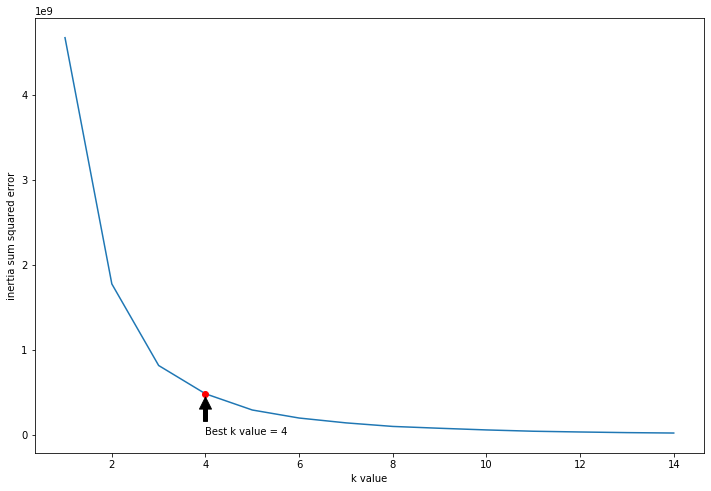

In [28]:
plt.figure(figsize=(12,8))
plt.plot(k, inertia)
plt.xlabel('k value')
plt.ylabel('inertia sum squared error')
plt.plot(k[3], inertia[3], 'ro')
plt.annotate(
    'Best k value = 4', xy=(k[3], inertia[3]),
    xytext = (4, 50), arrowprops = dict(facecolor='black', shrink=0.1)
)

## 2. Fitting Model And Predicting Cluster

In [29]:
# Fitting Model
model_KM = KMeans(n_clusters = 4, max_iter = 10000) #tingkatkan iterasi untuk meningkatkan kualitas prediksi 

model_KM.fit(rfm_segment_positive[['Frequency', 'Monetary']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [30]:
model_KM.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
#Predict Cluster

rfm_segment_positive['cluster'] = model_KM.predict(rfm_segment_positive[['Frequency', 'Monetary']])
rfm_segment_positive.head()

C:\Users\HP.LAPTOP-5BTBEJFV\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,cluster
CustomerID,,,,,,,,
12347,2,7,163.16,4,4,4,444,0
12348,75,4,331.36,2,3,4,234,0
12349,18,1,15.00,3,1,1,311,0
12350,310,1,25.20,1,1,2,112,0
12353,204,1,19.90,1,1,2,112,0


In [32]:
rfm_segment_positive['cluster'].describe()

count    4188.000000
mean        0.026266
std         0.226662
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: cluster, dtype: float64

## 3. Visualizing Cluster (Before Handling Outlier)

Text(0, 0.5, 'Monetary')

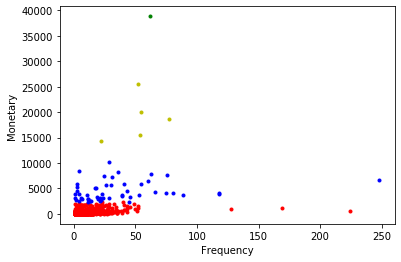

In [33]:
plt.plot(rfm_segment_positive['Frequency'][rfm_segment_positive['cluster'] == 0], 
         rfm_segment_positive['Monetary'][rfm_segment_positive['cluster'] == 0], 'r.')
plt.plot(rfm_segment_positive['Frequency'][rfm_segment_positive['cluster'] == 1], 
         rfm_segment_positive['Monetary'][rfm_segment_positive['cluster'] == 1], 'y.')
plt.plot(rfm_segment_positive['Frequency'][rfm_segment_positive['cluster'] == 2], 
         rfm_segment_positive['Monetary'][rfm_segment_positive['cluster'] == 2], 'b.')
plt.plot(rfm_segment_positive['Frequency'][rfm_segment_positive['cluster'] == 3], 
         rfm_segment_positive['Monetary'][rfm_segment_positive['cluster'] == 3], 'g.')
plt.xlabel('Frequency')
plt.ylabel('Monetary')

As you can see in the visualization above, we could not really see the cluster. this might be the impact of outliers in our dataframe. So, in my second trial of building Clustering Model, i will try to do it with handling the outliers.

# Handling Outliers in RFM Dataset

In [34]:
rfm_segmentation.describe()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,91.581199,5.075480,188.430071,2.510979,2.349039,2.495654
std,100.772139,9.338754,1046.488801,1.117084,1.151264,1.121830
min,0.000000,1.000000,-7899.590000,1.000000,1.000000,1.000000
25%,16.000000,1.000000,15.000000,2.000000,1.000000,1.000000
50%,50.000000,3.000000,39.500000,3.000000,2.000000,2.000000
75%,143.000000,5.000000,110.082500,4.000000,3.000000,3.250000
max,373.000000,248.000000,38834.790000,4.000000,4.000000,4.000000


### Detecting Outliers with Distribution Plot

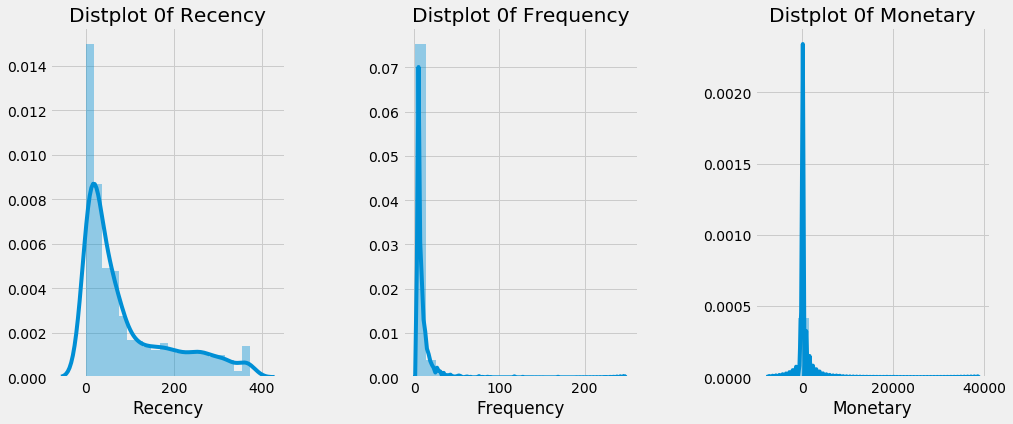

In [35]:
plt.style.use("fivethirtyeight")

plt.figure(1, figsize=(15,6))
n = 0
for x in ['Recency', 'Frequency', 'Monetary']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.distplot(rfm_segmentation[x], bins = 20)
    plt.title('Distplot 0f {}'.format(x))
plt.show()

From the Distribution Plot above, we could intuitively see that there is an outliers detected in each of the feature. To make sure that there is an outliers in out dataframe, I will try to do another outliers detection using BoxPlot

### Detecting Outliers using boxplot

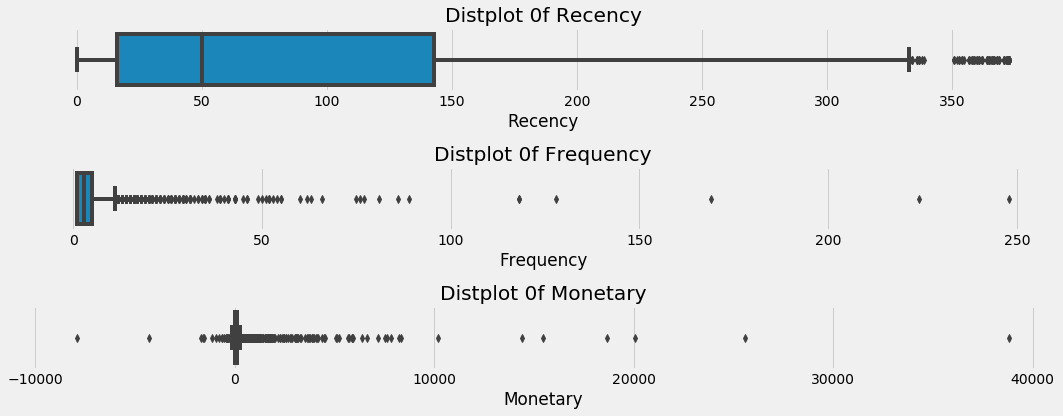

In [36]:
plt.style.use("fivethirtyeight")

plt.figure(1, figsize=(15,6))
n = 0
for x in ['Recency', 'Frequency', 'Monetary']:
    n += 1
    plt.subplot(3, 1, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.boxplot(rfm_segmentation[x])
    plt.title('Distplot 0f {}'.format(x))
plt.tight_layout()
plt.show()

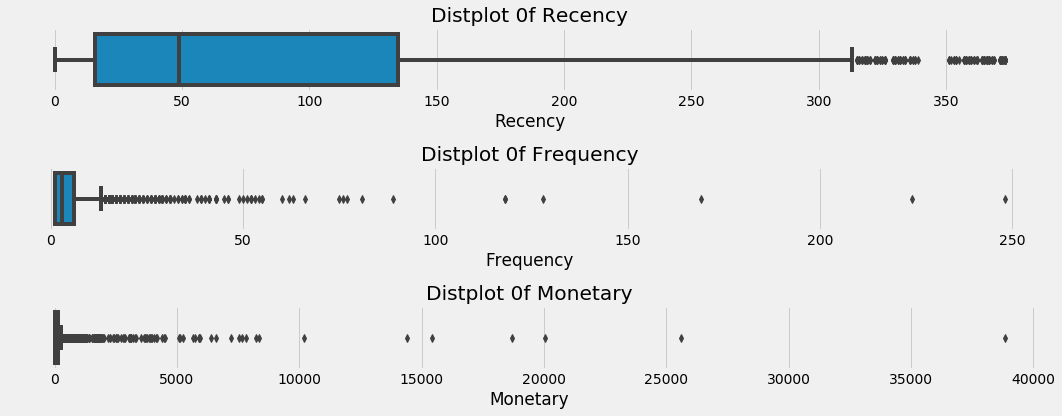

In [37]:
plt.style.use("fivethirtyeight")

plt.figure(1, figsize=(15,6))
n = 0
for x in ['Recency', 'Frequency', 'Monetary']:
    n += 1
    plt.subplot(3, 1, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.boxplot(rfm_segment_positive[x])
    plt.title('Distplot 0f {}'.format(x))
plt.tight_layout()
plt.show()

These Boxplot shows us that there are a lot of outliers in our dataframe. we could recognize it better this time. to make sure the exact number of outliers in our dataset, I am going to do one last Outliers Detection Technique using IQR Method. 

### Detecting Outliers Using IQR Method

In [42]:
Q1 = rfm_segmentation[i].describe()['25%']
Q2 = rfm_segmentation[i].describe()['50%']
Q3 = rfm_segmentation[i].describe()['75%']

IQR = (Q3 - Q1) * 1.5
batas_bawah= Q1-IQR
batas_atas = Q3+IQR

def find_outlier(yourlist):
    outlier = ''
    for i in range(len(yourlist)):
        if yourlist[i] > batas_atas:
            outlier += str(yourlist[i]) + ', '
        if yourlist[i] < batas_bawah:
            outlier += str(yourlist[i]) + ', '
    return outlier

In [43]:
cols = ['Recency', 'Frequency', 'Monetary']
for i in cols:
    if find_outlier(rfm_segment_positive[i].values) == []:
        print('Feature {} has NO Outliers'.format(i))
    else:
        print('Feature {} has {} Outliers '.format(i, len((find_outlier(rfm_segmentation[i].values)).split(','))))

Feature Recency has 498 Outliers 
Feature Frequency has 1 Outliers 
Feature Monetary has 541 Outliers 


## Handling Outliers Using Data Rescaling
As you can see in the IQR method above, there are a lot of outlier, almost 500 entries of the data. Due to the high number of the outliers, we could not just drop the outliers, because we will lost a lots of dataset. That is why i am going to use Rescalling Method by calculate the log values of each feature.

In [44]:
# Create a DataFrame without Minus(-) Transaction to avoid Infinite Number when calculate the Log value
rfm_positive = rfm_segment_positive[rfm_segment_positive['Recency']>0]

In [45]:
#Generate Feature of Logged value for each Recency, Frequency, and Monetary
for i in cols :
    rfm_positive['Log_of_{}'.format(i)] = [np.log(x) for x in rfm_positive[i]]

C:\Users\HP.LAPTOP-5BTBEJFV\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
rfm_positive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4152 entries, 12347 to 18287
Data columns (total 11 columns):
Recency             4152 non-null int64
Frequency           4152 non-null int64
Monetary            4152 non-null float64
R_Quartile          4152 non-null int64
F_Quartile          4152 non-null int64
M_Quartile          4152 non-null int64
RFMScore            4152 non-null object
cluster             4152 non-null int32
Log_of_Recency      4152 non-null float64
Log_of_Frequency    4152 non-null float64
Log_of_Monetary     4152 non-null float64
dtypes: float64(4), int32(1), int64(5), object(1)
memory usage: 373.0+ KB


In [47]:
rfm_positive.isna().sum()

Recency             0
Frequency           0
Monetary            0
R_Quartile          0
F_Quartile          0
M_Quartile          0
RFMScore            0
cluster             0
Log_of_Recency      0
Log_of_Frequency    0
Log_of_Monetary     0
dtype: int64

As you can see now we have only 4152 entries which means we lost around 200 entries, at least it is better than losing 500 entries. To make sure that we have handled the outliers, i try to visualize the Distribution Plot and Boxplot one more time

### Distribution Plot of Recency, Frequency, and Monetary after Outliers Handling with Data Rescalling

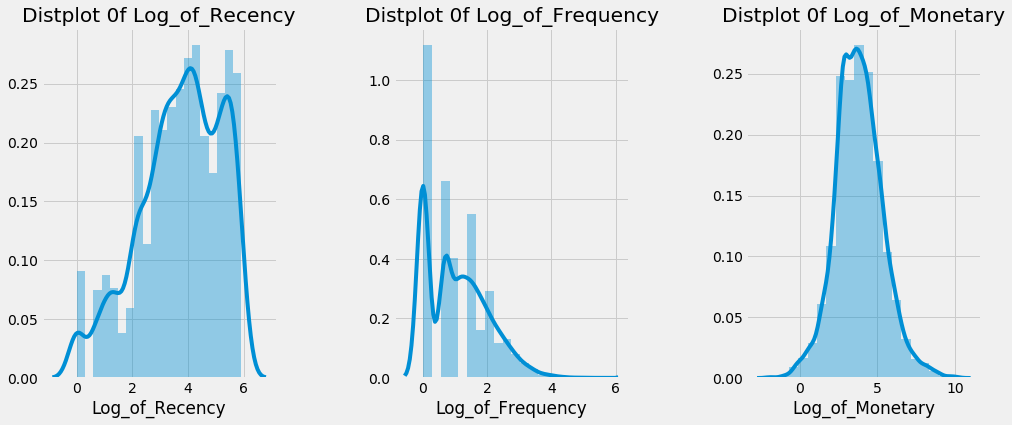

In [48]:
plt.style.use("fivethirtyeight")

plt.figure(1, figsize=(15,6))
n = 0
for x in ['Log_of_Recency', 'Log_of_Frequency', 'Log_of_Monetary']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.distplot(rfm_positive[x], bins = 20)
    plt.title('Distplot 0f {}'.format(x))
plt.show()

###  BoxPlot of Recency, Frequency, and Monetary after Outliers Handling with Data Rescalling

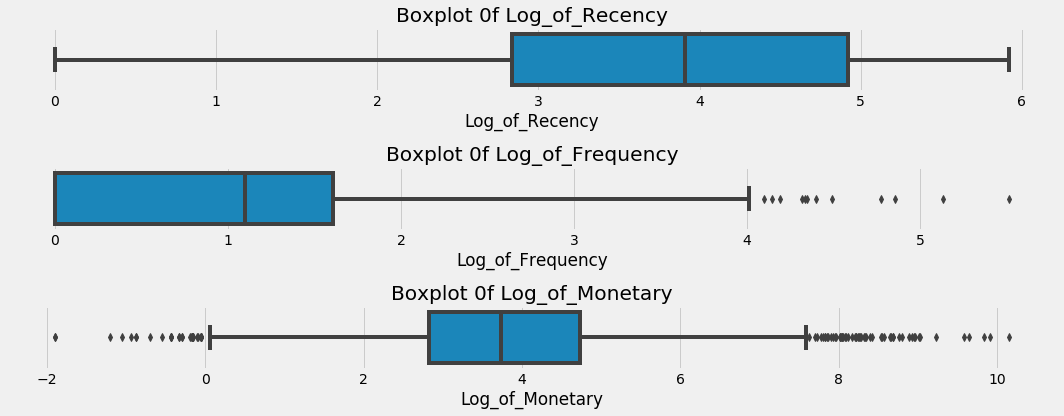

In [49]:
plt.style.use("fivethirtyeight")

plt.figure(1, figsize=(15,6))
n = 0
for x in ['Log_of_Recency', 'Log_of_Frequency', 'Log_of_Monetary']:
    n += 1
    plt.subplot(3, 1, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.boxplot(rfm_positive[x])
    plt.title('Boxplot 0f {}'.format(x))
plt.tight_layout()
plt.show()

As you can see the data distribution after rescaling is way better now. Now, let's try to build another clustering model using K-Means Clustering

## STEP 1 : Define K-Value
In this section, i will find K-Value for each combination below :
1. K Value for clustering model between Recency and Frequency
2. K Value for clustering model between Recency and Monetary
3. K value for clustering model between Monetary and Frequency

In [50]:
k = range(1, 15)
inertia = []
inertia_2 = []
inertia_3 = []

for i in k:
    model = KMeans(n_clusters = i)
    model_2 = KMeans(n_clusters = i)
    model_3 = KMeans(n_clusters = i)
    model.fit(rfm_positive[['Log_of_Recency', 'Log_of_Frequency']])
    model_2.fit(rfm_positive[['Log_of_Recency', 'Log_of_Monetary']])
    model_3.fit(rfm_positive[['Log_of_Monetary', 'Log_of_Frequency']])
    inertia.append(model.inertia_)
    inertia_2.append(model_2.inertia_)
    inertia_3.append(model_3.inertia_)

print(k)
print(inertia)
print(inertia_2)
print(inertia_3)

range(1, 15)
[12685.443939345216, 5582.979961067076, 3819.829693194581, 2954.4733637318627, 2342.654598558224, 1920.9691189783512, 1655.0410350673064, 1430.9389905290996, 1276.5129100266338, 1150.6434973117798, 1033.8033587179605, 954.6170626157163, 875.158134342068, 808.0894349829061]
[18503.58100467855, 10457.075097612687, 7917.471965088867, 6148.276820659866, 5130.631800373223, 4370.223613265901, 3776.30588006431, 3296.6125316759076, 2925.728676972738, 2647.165386870343, 2384.880944516835, 2180.818811874307, 2030.4640506446715, 1876.6297821508501]
[13279.209126165373, 5972.8545394481425, 4002.874815525385, 3152.8905490236953, 2545.9057996647916, 2112.1638341613557, 1836.3821912276762, 1611.2008166936396, 1437.6404831651987, 1301.179905131325, 1173.6303583248362, 1067.8592851118854, 983.6800248207002, 924.9745552869714]


Text(4, 50, 'Best k value = 4')

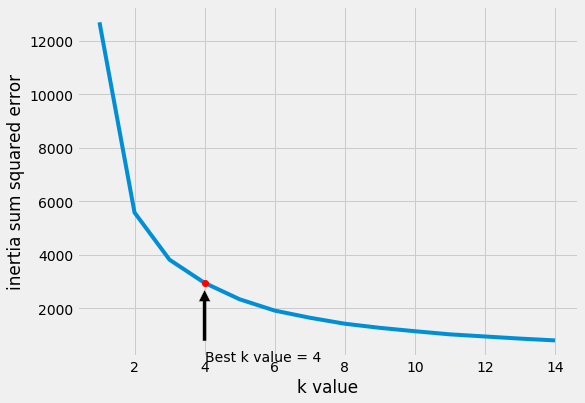

In [51]:
plt.figure(figsize=(8,6))
plt.plot(k, inertia)
plt.xlabel('k value')
plt.ylabel('inertia sum squared error')
plt.plot(k[3], inertia[3], 'ro')
plt.annotate(
    'Best k value = 4', xy=(k[3], inertia[3]),
    xytext = (4, 50), arrowprops = dict(facecolor='black', shrink=0.1)
)

Text(4, 50, 'Best k value = 3')

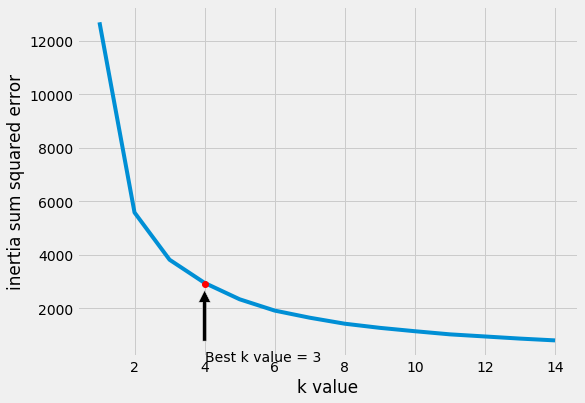

In [52]:
plt.figure(figsize=(8,6))
plt.plot(k, inertia)
plt.xlabel('k value')
plt.ylabel('inertia sum squared error')
plt.plot(k[3], inertia_2[8], 'ro')
plt.annotate(
    'Best k value = 3', xy=(k[3], inertia_2[8]),
    xytext = (4, 50), arrowprops = dict(facecolor='black', shrink=0.1)
)

Text(3, 50, 'Best k value = 3')

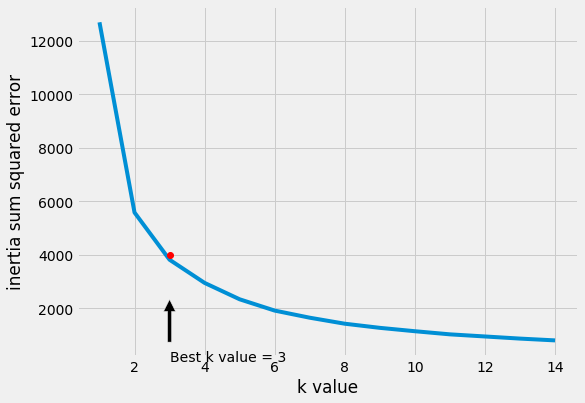

In [53]:
plt.figure(figsize=(8,6))
plt.plot(k, inertia)
plt.xlabel('k value')
plt.ylabel('inertia sum squared error')
plt.plot(k[2], inertia_3[2], 'ro')
plt.annotate(
    'Best k value = 3', xy=(k[2], inertia_3[4]),
    xytext = (3, 50), arrowprops = dict(facecolor='black', shrink=0.1)
)

From the Elbow Method above, we could conclude that :
1. K value for model 1 = 4
2. K Value for model 2 = 4
3. K Value for model 3 = 3


## STEP 2 : Model Fitting and Prediction
after i find the K Values for each model, I try to Fit these model with different feature inside, After that, I try to predict the clusters for each model

In [54]:
# Fitting Model
model_KM = KMeans(n_clusters = 4, max_iter = 10000)#tingkatkan iterasi untuk meningkatkan kualitas prediksi 
model_KM_3 = KMeans(n_clusters = 3, max_iter = 10000)

model_KM.fit(rfm_positive[['Log_of_Recency', 'Log_of_Frequency']])
model_KM.fit(rfm_positive[['Log_of_Recency', 'Log_of_Monetary']])
model_KM_3.fit(rfm_positive[['Log_of_Monetary', 'Log_of_Frequency']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [55]:
#Predict Cluster

rfm_positive['K-Means_RF'] = model_KM.predict(rfm_positive[['Log_of_Recency', 'Log_of_Frequency']])
rfm_positive['K-Means_RM'] = model_KM.predict(rfm_positive[['Log_of_Recency', 'Log_of_Monetary']])
rfm_positive['K-Means_MF'] = model_KM_3.predict(rfm_positive[['Log_of_Monetary', 'Log_of_Frequency']])
rfm_positive.head()

C:\Users\HP.LAPTOP-5BTBEJFV\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP.LAPTOP-5BTBEJFV\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\HP.LAPTOP-5BTBEJFV\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a cop

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,cluster,Log_of_Recency,Log_of_Frequency,Log_of_Monetary,K-Means_RF,K-Means_RM,K-Means_MF
CustomerID,,,,,,,,,,,,,,
12347,2,7,163.16,4,4,4,444,0,0.693147,1.945910,5.094731,1,2,2
12348,75,4,331.36,2,3,4,234,0,4.317488,1.386294,5.803205,0,3,2
12349,18,1,15.00,3,1,1,311,0,2.890372,0.000000,2.708050,1,1,1
12350,310,1,25.20,1,1,2,112,0,5.736572,0.000000,3.226844,0,0,1
12353,204,1,19.90,1,1,2,112,0,5.318120,0.000000,2.990720,0,0,1


In [56]:
rfm_positive[rfm_positive['K-Means_RF']==3]

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,cluster,Log_of_Recency,Log_of_Frequency,Log_of_Monetary,K-Means_RF,K-Means_RM,K-Means_MF
CustomerID,,,,,,,,,,,,,,
16029,38,76,7660.93,3,4,4,344,2,3.637586,4.330733,8.943889,3,2,2


## STEP 3 : Cluster Visualization
Since there are 3 model of clustering in this projects, I Will try to visualize each of the model

### Clustering 1 : Monetary vs Recency

In [57]:
plt.style.use("fivethirtyeight")

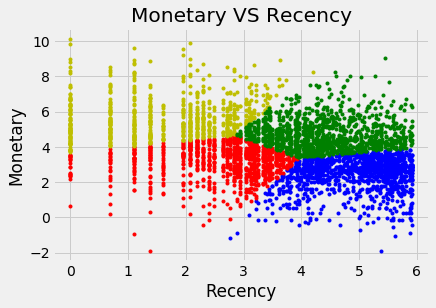

In [59]:
plt.plot(rfm_positive['Log_of_Recency'][rfm_positive['K-Means_RM'] == 0], 
         rfm_positive['Log_of_Monetary'][rfm_positive['K-Means_RM'] == 0], 'b.')
plt.plot(rfm_positive['Log_of_Recency'][rfm_positive['K-Means_RM'] == 1], 
         rfm_positive['Log_of_Monetary'][rfm_positive['K-Means_RM'] == 1], 'r.')
plt.plot(rfm_positive['Log_of_Recency'][rfm_positive['K-Means_RM'] == 2], 
         rfm_positive['Log_of_Monetary'][rfm_positive['K-Means_RM'] == 2], 'y.')
plt.plot(rfm_positive['Log_of_Recency'][rfm_positive['K-Means_RM'] == 3], 
         rfm_positive['Log_of_Monetary'][rfm_positive['K-Means_RM'] == 3], 'g.')
plt.title("Monetary VS Recency")
plt.xlabel('Recency')
plt.ylabel('Monetary')

#Saving Plot for dashboards
plt.savefig(r"C:\Users\HP.LAPTOP-5BTBEJFV\Documents\data science\MODULE 3\FINAL PROJECT\dashboard\static\monetary vs recency.png", 
           bbox_inches='tight', dpi=150)

### Clustering 2 : Frequency vs Recency

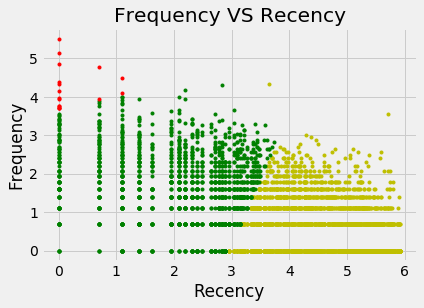

In [61]:
plt.plot(rfm_positive['Log_of_Recency'][rfm_positive['K-Means_RF'] == 0], 
         rfm_positive['Log_of_Frequency'][rfm_positive['K-Means_RF'] == 0], 'y.')
plt.plot(rfm_positive['Log_of_Recency'][rfm_positive['K-Means_RF'] == 1], 
         rfm_positive['Log_of_Frequency'][rfm_positive['K-Means_RF'] == 1], 'g.')
plt.plot(rfm_positive['Log_of_Recency'][rfm_positive['K-Means_RF'] == 2], 
         rfm_positive['Log_of_Frequency'][rfm_positive['K-Means_RF'] == 2], 'r.')
plt.plot(rfm_positive['Log_of_Recency'][rfm_positive['K-Means_RF'] == 3], 
         rfm_positive['Log_of_Frequency'][rfm_positive['K-Means_RF'] == 3], 'y.')
plt.title("Frequency VS Recency")
plt.xlabel('Recency')
plt.ylabel('Frequency')

#Saving Plot for dashboards
plt.savefig(r"C:\Users\HP.LAPTOP-5BTBEJFV\Documents\data science\MODULE 3\FINAL PROJECT\dashboard\static\frequency vs recency.png", 
           bbox_inches='tight', dpi=150)

### Clustering 3 : Monetary vs Frequency

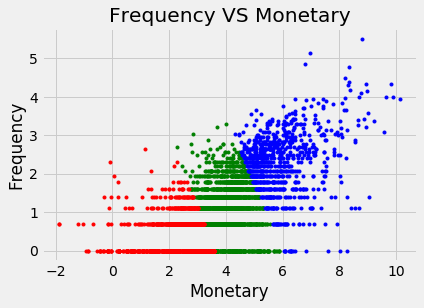

In [62]:
plt.plot(rfm_positive['Log_of_Monetary'][rfm_positive['K-Means_MF'] == 0], 
         rfm_positive['Log_of_Frequency'][rfm_positive['K-Means_MF'] == 0], 'g.')
plt.plot(rfm_positive['Log_of_Monetary'][rfm_positive['K-Means_MF'] == 1], 
         rfm_positive['Log_of_Frequency'][rfm_positive['K-Means_MF'] == 1], 'r.')
plt.plot(rfm_positive['Log_of_Monetary'][rfm_positive['K-Means_MF'] == 2], 
         rfm_positive['Log_of_Frequency'][rfm_positive['K-Means_MF'] == 2], 'b.')
plt.title("Frequency VS Monetary")
plt.xlabel('Monetary')
plt.ylabel('Frequency')

#Saving Plot for dashboards
plt.savefig(r"C:\Users\HP.LAPTOP-5BTBEJFV\Documents\data science\MODULE 3\FINAL PROJECT\dashboard\static\frequency vs monetary.png", 
           bbox_inches='tight', dpi=150)

In [145]:
data.head()

,InvoiceNo,InvoiceDate,Date,Years,Months,Days,Hours,DayOfMonth,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalCost,K-Means_Cluster
0,536365,2010-12-01 08:26:00,2010-12-01,2010,12,3,8,1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30,Group 4
1,536366,2010-12-01 08:28:00,2010-12-01,2010,12,3,8,1,22633,HAND WARMER UNION JACK,6,1.85,17850,United Kingdom,11.10,Group 4
2,536367,2010-12-01 08:34:00,2010-12-01,2010,12,3,8,1,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1.69,13047,United Kingdom,54.08,Group 4
3,536368,2010-12-01 08:34:00,2010-12-01,2010,12,3,8,1,22960,JAM MAKING SET WITH JARS,6,4.25,13047,United Kingdom,25.50,Group 4
4,536369,2010-12-01 08:35:00,2010-12-01,2010,12,3,8,1,21756,BATH BUILDING BLOCK WORD,3,5.95,13047,United Kingdom,17.85,Group 4


In [146]:
data.to_csv("E-Commerce_data_after_clustering.csv", index=False)

In [64]:
cek_data_cluster = pd.read_csv("E-Commerce_data_after_clustering.csv")
cek_data_cluster.columns

Index(['InvoiceNo', 'InvoiceDate', 'Date', 'Years', 'Months', 'Days', 'Hours',
       'DayOfMonth', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country', 'TotalCost'],
      dtype='object')

## Clustering Evaluation and Cluster Exploration
In this projects, i am trying to do customer segmentation using RFM Analysis. In analyzing the RFM value i am using 2 methods which is Quantiles Method and K-Means Clustering. From those ways, i get 2 different clustering results. In Quantiles Method, I get 6 different group or clusters which is :
1. Best Customers (409) : Bought most recently and most often, and spend the most
2. Loyal Customers (1087) : Buy most frequently
3. Big Spenders (1093) : Spend the most
4. Almost Lost (79) : Haven’t purchased for some time, but purchased frequently and spend the most
5. Lost Customers (14) : 	Haven’t purchased for some time, but purchased frequently and spend the most
6. Lost Cheap Customers (298) : Last purchased long ago, purchased few, and spent little

This number of cluster and the name of each cluster is based on academic article written by Joao Correia (2016). for more details about clustering using Quantiles Method by Joao you can visit this site : https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales . 

From this six clusters, we can give a data-driven **Business Insights** as follows :
1. For Best Customers, we shouldn't give any price incentives. Instead, we can offer some new products, and loyalty programs.
2. For Loyal Customers, we can offer some new products and try to give a price incentives on expensive products. 
3. For Big Spenders, we can market our most expensive products on this kind of customers
4. For Almost Lost and Lost Customers, we should give an aggresive Price Incentive
5. For Lost Cheap Customers, we shouldn't spend too much resources on trying to re-acquire this segment

In spite of that, we also had another clustering method; K-Means Clustering. In this clustering, I try to make 3 clustering model based on R-F, M-R, and M-F. The clustering results shows us that the  Monetary-Recency clustering is the best result. This clustering is prefered due to higher information level provided in the results. in M-R clustering, we get a clear 4 different groups as shown in the visualilzation above. This 4 different groups has different behavior as follows :
1. Group 1 (red dots) : Customers with low Monetary and Low Recency
2. Group 2 (blue dots) : Customers with low Monetary but has a high Recency
3. Group 3 (yellow dots) : Customers with a high Monetary but has a low Recency
4. Group 4 (green dots) : Customers with a high Monetary and also high Recency

From this four clusters, we can give a data-driven **Business Insights** as follows :
1. For group 1, we should give an aggresive Price Incentive and aggresive marketing strategy
2. For group 2, we should give a recommendation of some new products and give a moderate price incentive
3. For group 3, we should try to make innovation on our products and marketing such as collaboration with influencer and other public figure to attract these customers whose starting to churn
4. For group 4. we shouldn't give any price incentives. Instead, we can offer some new products, and loyalty programs.


## 4. Cluster Exploration
In this cluster exploration, i am going to cover business question below :
1. How many Customer for each group/cluster?
2. How does each cluster/group contribute to the company's revenue?
3. What is the common stock ordered in each group?
4. When does each cluster usually made an order?
5. How does each cluster react on a discounts?

I will answer all of the business question above by using the clustering results from **K-Means Clustering** Model

### 1. How many customers for each group/cluster?

In [131]:
cluster_member = pd.DataFrame({"Group 1" : [len(rfm_positive[rfm_positive["K-Means_RM"]==1])],
              "Group 2" : len(rfm_positive[rfm_positive["K-Means_RM"]==0]),
              "Group 3" : len(rfm_positive[rfm_positive["K-Means_RM"]==2]),
              "Group 4" : len(rfm_positive[rfm_positive["K-Means_RM"]==3])}).T
cluster_member.columns = ['number_of_member']
cluster_member.sort_values('number_of_member')

,number_of_member
Group 3,692
Group 1,949
Group 4,1202
Group 2,1309


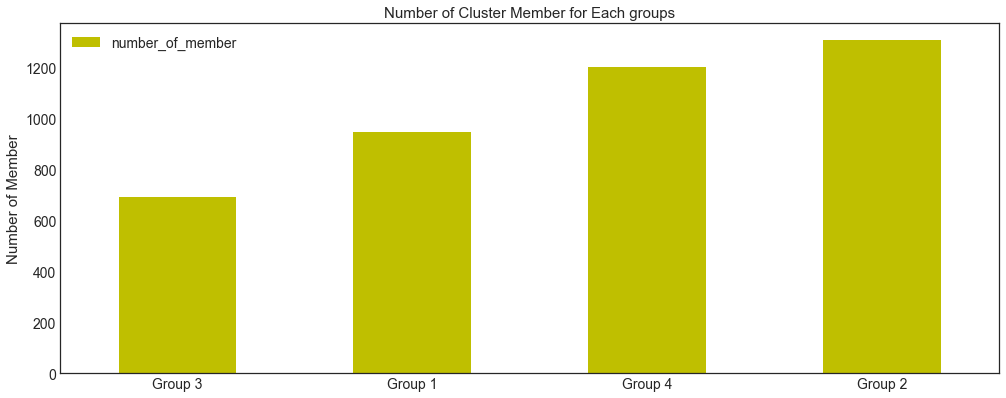

In [133]:
plt.style.use('seaborn-white')

fig, ax1 = plt.subplots(figsize=(15, 6))
ax1 = cluster_member.sort_values('number_of_member')['number_of_member'].plot(kind='bar', color='y')
ax1.set_ylabel('Number of Member',fontsize=15)
ax1.set_title('Number of Cluster Member for Each groups',fontsize=15)
plt.xticks(rotation=(0))
plt.legend()

#Saving Plot for dashboards
plt.savefig(r"C:\Users\HP.LAPTOP-5BTBEJFV\Documents\data science\MODULE 3\FINAL PROJECT\dashboard\static\number of each group.png", 
           bbox_inches='tight', dpi=150)
plt.show()

### 2. How does each cluster/group contribute to the company's revenue?

In [101]:
rfm_positive.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,cluster,Log_of_Recency,Log_of_Frequency,Log_of_Monetary,K-Means_RF,K-Means_RM,K-Means_MF
CustomerID,,,,,,,,,,,,,,
12347,2,7,163.16,4,4,4,444,0,0.693147,1.945910,5.094731,1,2,2
12348,75,4,331.36,2,3,4,234,0,4.317488,1.386294,5.803205,0,3,2
12349,18,1,15.00,3,1,1,311,0,2.890372,0.000000,2.708050,1,1,1
12350,310,1,25.20,1,1,2,112,0,5.736572,0.000000,3.226844,0,0,1
12353,204,1,19.90,1,1,2,112,0,5.318120,0.000000,2.990720,0,0,1


In [102]:
group_1 = rfm_positive[rfm_positive["K-Means_RM"]==1].index
group_2 = rfm_positive[rfm_positive["K-Means_RM"]==0].index
group_3 = rfm_positive[rfm_positive["K-Means_RM"]==2].index
group_4 = rfm_positive[rfm_positive["K-Means_RM"]==3].index

In [103]:
list_cluster = []
for i in data['CustomerID']:
    if i in list(group_1) :
        list_cluster.append('Group 1')
    elif i in list(group_2) :
        list_cluster.append('Group 2')
    elif i in list(group_3) :
        list_cluster.append('Group 3')
    elif i in list(group_4) :
        list_cluster.append('Group 4')
    else:
        list_cluster.append('Outlier')

In [104]:
data['K-Means_Cluster'] = list_cluster
data.head()

,InvoiceNo,InvoiceDate,Date,Years,Months,Days,Hours,DayOfMonth,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalCost,K-Means_Cluster
0,536365,2010-12-01 08:26:00,2010-12-01,2010,12,3,8,1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30,Group 4
1,536366,2010-12-01 08:28:00,2010-12-01,2010,12,3,8,1,22633,HAND WARMER UNION JACK,6,1.85,17850,United Kingdom,11.10,Group 4
2,536367,2010-12-01 08:34:00,2010-12-01,2010,12,3,8,1,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1.69,13047,United Kingdom,54.08,Group 4
3,536368,2010-12-01 08:34:00,2010-12-01,2010,12,3,8,1,22960,JAM MAKING SET WITH JARS,6,4.25,13047,United Kingdom,25.50,Group 4
4,536369,2010-12-01 08:35:00,2010-12-01,2010,12,3,8,1,21756,BATH BUILDING BLOCK WORD,3,5.95,13047,United Kingdom,17.85,Group 4


In [105]:
data.isna().sum()

InvoiceNo          0
InvoiceDate        0
Date               0
Years              0
Months             0
Days               0
Hours              0
DayOfMonth         0
StockCode          0
Description        0
Quantity           0
UnitPrice          0
CustomerID         0
Country            0
TotalCost          0
K-Means_Cluster    0
dtype: int64

In [106]:
ord_rev_cluster = pd.DataFrame({"Revenue" : data.groupby('K-Means_Cluster')['TotalCost'].sum(),
                                "Order" :data.groupby('K-Means_Cluster')['Quantity'].sum()})
ord_rev_cluster.drop(['Outlier'], inplace=True)
ord_rev_cluster

,Revenue,Order
K-Means_Cluster,,
Group 1,31121.03,21690
Group 2,20771.26,14098
Group 3,517033.78,298884
Group 4,214032.11,137232


In [134]:
# pie plot
import plotly.express as px

fig = px.pie(ord_rev_cluster['Revenue'],
             values=ord_rev_cluster['Revenue'].values,
             names=ord_rev_cluster['Revenue'].index,
             title="Clusters Contribution by Revenue",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
#Saving Plot for dashboards

fig.show()

#### 3. What is the common stock ordered in each group

In [108]:
top_5_1 = data[data['K-Means_Cluster']=='Group 1'].sort_values(by='Quantity', ascending=False).head()['Description']
top_5_2 = data[data['K-Means_Cluster']=='Group 2'].sort_values(by='Quantity', ascending=False).head()['Description']
top_5_3 = data[data['K-Means_Cluster']=='Group 3'].sort_values(by='Quantity', ascending=False).head()['Description']
top_5_4 = data[data['K-Means_Cluster']=='Group 4'].sort_values(by='Quantity', ascending=False).head()['Description']

top_price_1 = data[data['K-Means_Cluster']=='Group 1'].sort_values(by='Quantity', ascending=False).head(10)['UnitPrice']
top_price_2 = data[data['K-Means_Cluster']=='Group 2'].sort_values(by='Quantity', ascending=False).head(10)['UnitPrice']
top_price_3 = data[data['K-Means_Cluster']=='Group 3'].sort_values(by='Quantity', ascending=False).head(10)['UnitPrice']
top_price_4 = data[data['K-Means_Cluster']=='Group 4'].sort_values(by='Quantity', ascending=False).head(10)['UnitPrice']


In [109]:
temp_stock = pd.DataFrame()
temp_stock.insert(loc=0, value=top_5_1.values, column='Group 1')
temp_stock.insert(loc=1, value=top_5_2.values, column='Group 2')
temp_stock.insert(loc=2, value=top_5_3.values, column='Group 3')
temp_stock.insert(loc=3, value=top_5_4.values, column='Group 4')
temp_stock

,Group 1,Group 2,Group 3,Group 4
0,WOODEN STAR CHRISTMAS SCANDINAVIAN,CARTOON PENCIL SHARPENERS,SMALL CHINESE STYLE SCISSOR,SMALL POPCORN HOLDER
1,BLUE POLKADOT WRAP,POPART WOODEN PENCILS ASST,WORLD WAR 2 GLIDERS ASSTD DESIGNS,EMPIRE DESIGN ROSETTE
2,ANIMAL STICKERS,POPART WOODEN PENCILS ASST,GROW A FLYTRAP OR SUNFLOWER IN TIN,ESSENTIAL BALM 3.5g TIN IN ENVELOPE
3,TEATIME GEL PENS ASST,POPART WOODEN PENCILS ASST,RABBIT NIGHT LIGHT,WORLD WAR 2 GLIDERS ASSTD DESIGNS
4,BROCADE RING PURSE,CARTOON PENCIL SHARPENERS,RABBIT NIGHT LIGHT,ESSENTIAL BALM 3.5g TIN IN ENVELOPE


In [110]:
price_cluster = pd.DataFrame()
price_cluster.insert(loc=0, value=top_price_1.values, column='Group 1')
price_cluster.insert(loc=1, value=top_price_2.values, column='Group 2')
price_cluster.insert(loc=2, value=top_price_3.values, column='Group 3')
price_cluster.insert(loc=3, value=top_price_4.values, column='Group 4')
price_cluster

,Group 1,Group 2,Group 3,Group 4
0,0.29,0.06,0.32,0.72
1,0.36,0.04,0.21,0.82
2,0.21,0.04,0.94,0.06
3,0.12,0.04,2.08,0.18
4,0.29,0.06,1.79,0.06
5,0.19,0.06,0.32,2.40
6,0.12,0.06,0.32,2.55
7,0.36,0.19,0.72,0.17
8,0.04,0.21,0.55,0.32
9,0.04,0.42,0.85,2.55


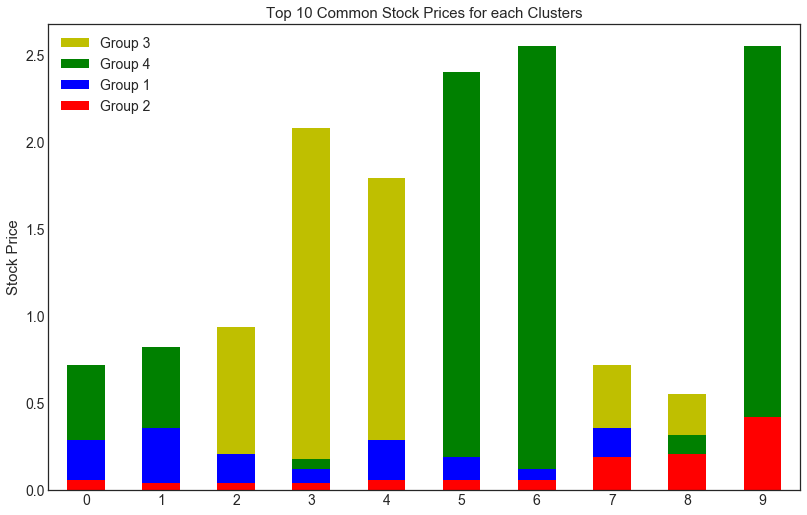

In [113]:
plt.style.use('seaborn-white')

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1 = price_cluster['Group 3'].plot(kind='bar', color='y')
ax2 = price_cluster['Group 4'].plot(kind='bar', color='g')
ax3 = price_cluster['Group 1'].plot(kind='bar', color='b')
ax4 = price_cluster['Group 2'].plot(kind='bar', color='r')

ax1.set_ylabel('Stock Price',fontsize=15)
ax1.set_title('Top 10 Common Stock Prices for each Clusters',fontsize=15)

plt.xticks(rotation=(0))
plt.legend()
#Saving Plot for dashboards
plt.savefig(r"C:\Users\HP.LAPTOP-5BTBEJFV\Documents\data science\MODULE 3\FINAL PROJECT\dashboard\static\op 10 Common Stock Prices.png", 
           bbox_inches='tight', dpi=150)

plt.show()

From the Visualization above, we could see that Group 3 and 2 has a tendency to buy a more expensive stocks. it is shown that the most favorite stocks ordered by group 3 and 2 are in the high price. In contrary, group 1 and 4 has a tendency to buy a low price stocks. This could be a valuable information for Marketing Team to do :
1. maximize conversion rate for expensive stocks from Group 3 and 2
2. maximize conversion rate for low price stocks from Group 1 and 4

#### 4. When does each cluster usually made an order?

In [114]:
data[data['K-Means_Cluster']=='Group 1']

,InvoiceNo,InvoiceDate,Date,Years,Months,Days,Hours,DayOfMonth,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalCost,K-Means_Cluster
27,536392,2010-12-01 10:29:00,2010-12-01,2010,12,3,10,1,22150,3 STRIPEY MICE FELTCRAFT,6,1.95,13705,United Kingdom,11.70,Group 1
33,536398,2010-12-01 10:52:00,2010-12-01,2010,12,3,10,1,21980,PACK OF 12 RED RETROSPOT TISSUES,24,0.29,13448,United Kingdom,6.96,Group 1
35,536400,2010-12-01 10:53:00,2010-12-01,2010,12,3,10,1,22969,HOMEMADE JAM SCENTED CANDLES,12,1.45,13448,United Kingdom,17.40,Group 1
36,536401,2010-12-01 11:21:00,2010-12-01,2010,12,3,11,1,22110,BIRD HOUSE HOT WATER BOTTLE,1,2.55,15862,United Kingdom,2.55,Group 1
46,536415,2010-12-01 11:57:00,2010-12-01,2010,12,3,11,1,22952,60 CAKE CASES VINTAGE CHRISTMAS,10,0.55,12838,United Kingdom,5.50,Group 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22119,581450,2011-12-08 17:54:00,2011-12-08,2011,12,4,17,8,22348,TEA BAG PLATE RED RETROSPOT,2,0.85,16794,United Kingdom,1.70,Group 1
22120,581451,2011-12-08 17:57:00,2011-12-08,2011,12,4,17,8,21115,ROSE CARAVAN DOORSTOP,8,1.95,17144,United Kingdom,15.60,Group 1
22133,C581464,2011-12-08 18:57:00,2011-12-08,2011,12,4,18,8,23458,DOLLY CABINET 3 DRAWERS,-1,14.95,15951,United Kingdom,-14.95,Group 1
22135,C581466,2011-12-08 19:20:00,2011-12-08,2011,12,4,19,8,22838,3 TIER CAKE TIN RED AND CREAM,-1,14.95,13883,United Kingdom,-14.95,Group 1


In [115]:
hours_group = pd.DataFrame()
hours_group1 = pd.DataFrame(data[data['K-Means_Cluster']=='Group 1'].groupby('Hours').sum()['Quantity'])
hours_group2 = pd.DataFrame(data[data['K-Means_Cluster']=='Group 2'].groupby('Hours').sum()['Quantity'])
hours_group3 = pd.DataFrame(data[data['K-Means_Cluster']=='Group 3'].groupby('Hours').sum()['Quantity'])
hours_group4 = pd.DataFrame(data[data['K-Means_Cluster']=='Group 4'].groupby('Hours').sum()['Quantity'])

hours_group1.insert(loc=1, value=hours_group2['Quantity'], column='Group 2')
hours_group1.insert(loc=2, value=hours_group3['Quantity'], column='Group 3')
hours_group1.insert(loc=3, value=hours_group4['Quantity'], column='Group 4')
hours_group1

,Quantity,Group 2,Group 3,Group 4
Hours,,,,
6,-4,-5,-33,-11
7,20,50,2262,169
8,839,495,9841,3291
9,1354,1223,26529,10213
10,1919,1873,48077,24677
11,3200,1589,45137,10833
12,3568,1946,57987,30173
13,3745,2024,38929,16312
14,2481,1897,15579,14007


In [135]:
fig = px.pie(hours_group1['Quantity'],
             values=hours_group1['Quantity'].values,
             names=hours_group1['Quantity'].index,
             title="Hour Distribution of Order Made by Group 1",
             template="seaborn")
fig.update_traces(rotation=90, textinfo="percent+label")
fig.show()

In [136]:
fig = px.pie(hours_group1['Group 2'],
             values=hours_group1['Group 2'].values,
             names=hours_group1['Group 2'].index,
             title="Hour Distribution of Order Made by Group 2",
             template="seaborn")
fig.update_traces(rotation=90, textinfo="percent+label")
fig.show()

In [137]:
fig = px.pie(hours_group1['Group 3'],
             values=hours_group1['Group 3'].values,
             names=hours_group1['Group 3'].index,
             title="Hour Distribution of Order Made by Group 3",
             template="seaborn")
fig.update_traces(rotation=90, textinfo="percent+label")
fig.show()

In [138]:
fig = px.pie(hours_group1['Group 4'],
             values=hours_group1['Group 4'].values,
             names=hours_group1['Group 4'].index,
             title="Hour Distribution of Order Made by Group 4",
             template="seaborn")
fig.update_traces(rotation=90, textinfo="percent+label")
fig.show()

In [120]:
date_group1 = pd.DataFrame(data[data['K-Means_Cluster']=='Group 1'].groupby('DayOfMonth').sum()['Quantity'])
date_group2 = pd.DataFrame(data[data['K-Means_Cluster']=='Group 2'].groupby('DayOfMonth').sum()['Quantity'])
date_group3 = pd.DataFrame(data[data['K-Means_Cluster']=='Group 3'].groupby('DayOfMonth').sum()['Quantity'])
date_group4 = pd.DataFrame(data[data['K-Means_Cluster']=='Group 4'].groupby('DayOfMonth').sum()['Quantity'])

date_group1.insert(loc=1, value=date_group2['Quantity'], column='Group 2')
date_group1.insert(loc=2, value=date_group3['Quantity'], column='Group 3')
date_group1.insert(loc=3, value=date_group4['Quantity'], column='Group 4')
date_group1

,Quantity,Group 2,Group 3,Group 4
DayOfMonth,,,,
1,1366,587,12248,4134
2,576,438,10031,5473
3,364,505,10882,2677
4,836,361,9407,2369
5,881,481,13494,5002
6,817,322,12435,3896
7,811,795,13141,5701
8,711,495,9902,6458
9,610,657,9929,4133


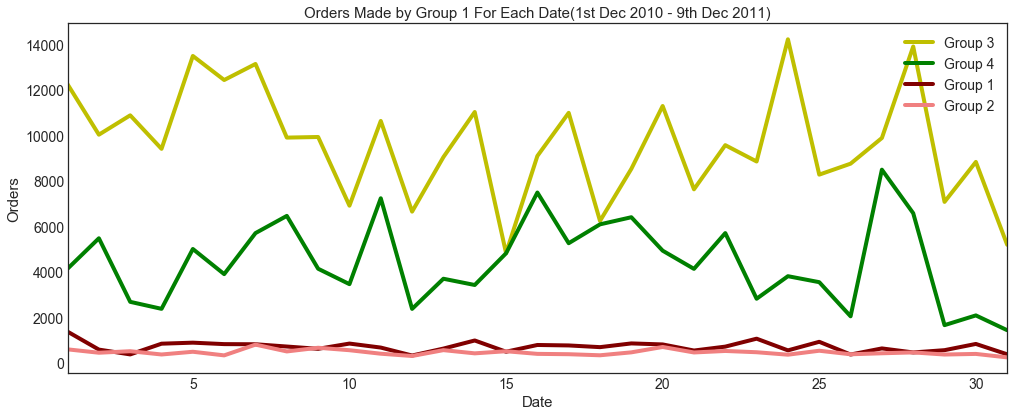

In [143]:
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1 = date_group1['Group 3'].plot(kind='line', color='y', label='Group 3')
ax2 = date_group1['Group 4'].plot(kind='line', color='g', label='Group 4')
ax3 = date_group1['Quantity'].plot(kind='line', color='maroon', label='Group 1')
ax4 = date_group1['Group 2'].plot(kind='line', color='lightcoral', label='Group 2')

ax1.set_xlabel('Date',fontsize=15)
ax1.set_ylabel('Orders',fontsize=15)
ax1.set_title('Orders Made by Group 1 For Each Date(1st Dec 2010 - 9th Dec 2011)',fontsize=15)
plt.legend()
#Saving Plot for dashboards
plt.savefig(r"C:\Users\HP.LAPTOP-5BTBEJFV\Documents\data science\MODULE 3\FINAL PROJECT\dashboard\static\order made all.png", 
           bbox_inches='tight', dpi=150)
plt.show()

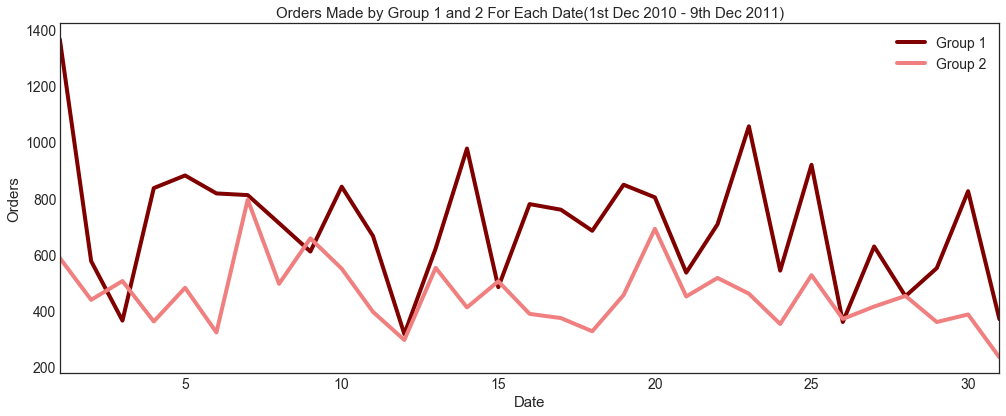

In [144]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax3 = date_group1['Quantity'].plot(kind='line', color='maroon', label='Group 1')
ax4 = date_group1['Group 2'].plot(kind='line', color='lightcoral', label='Group 2')

ax1.set_xlabel('Date',fontsize=15)
ax1.set_ylabel('Orders',fontsize=15)
ax1.set_title('Orders Made by Group 1 and 2 For Each Date(1st Dec 2010 - 9th Dec 2011)',fontsize=15)
plt.legend()

#Saving Plot for dashboards
plt.savefig(r"C:\Users\HP.LAPTOP-5BTBEJFV\Documents\data science\MODULE 3\FINAL PROJECT\dashboard\static\order made 1 2.png", 
           bbox_inches='tight', dpi=150)
plt.show()

#### 5. How does each cluster react on a discounts?

In [123]:
months = ['january', 'february', 'march', 'april', 'may', 'june', 
          'july', 'august', 'september', 'october', 'november', 'desember']

disc_count = []
mon_ord = []
mon_ord_1 = []
mon_ord_2 = []
mon_ord_3 = []
mon_ord_4 = []

for i in range(1,13):
    mon_ord.append(data[data['Months'] == i]['Quantity'].sum())
    mon_ord_1.append(data[(data['Months'] == i)&(data['K-Means_Cluster']=='Group 1')]['Quantity'].sum())
    mon_ord_2.append(data[(data['Months'] == i)&(data['K-Means_Cluster']=='Group 2')]['Quantity'].sum())
    mon_ord_3.append(data[(data['Months'] == i)&(data['K-Means_Cluster']=='Group 3')]['Quantity'].sum())
    mon_ord_4.append(data[(data['Months'] == i)&(data['K-Means_Cluster']=='Group 4')]['Quantity'].sum())    
    disc_count.append(data[(data['StockCode']=='D') &(data['Months'] == i)]['StockCode'].count())
    
disc_ord = pd.DataFrame({'num_of_disc': disc_count, "Group 1": mon_ord_1, "Group 2": mon_ord_2,
                         "Group 3": mon_ord_3, "Group 4": mon_ord_4}, index=months)
disc_ord

,num_of_disc,Group 1,Group 2,Group 3,Group 4
january,1,463,895,15784,8296
february,3,597,952,19485,14818
march,5,876,1358,19375,8965
april,3,708,1204,18474,9292
may,7,1216,964,23372,17368
june,7,928,1406,17584,11177
july,5,1015,1170,19557,14584
august,9,1020,1071,20053,10719
september,7,1463,1868,26214,13205
october,2,2474,1991,35375,10590


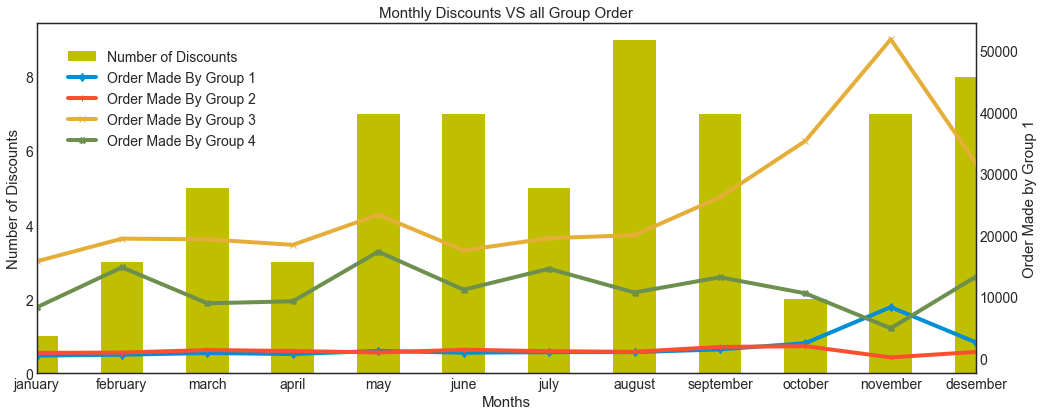

In [140]:
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1 = disc_ord['num_of_disc'].plot(kind='bar', color='y', label='Number of Discounts')
ax2 = disc_ord['Group 1'].plot(kind='line', marker='d', secondary_y=True, label = 'Order Made By Group 1')
ax3 = disc_ord['Group 2'].plot(kind='line', marker='+', secondary_y=True, label = 'Order Made By Group 2')
ax4 = disc_ord['Group 3'].plot(kind='line', marker='x', secondary_y=True, label = 'Order Made By Group 3')
ax5 = disc_ord['Group 4'].plot(kind='line', marker='X', secondary_y=True, label = 'Order Made By Group 4')

ax1.set_xlabel('Months',fontsize=15)
ax1.set_ylabel('Number of Discounts',fontsize=15)
ax2.set_ylabel('Order Made by Group 1',fontsize=15)
ax1.set_title('Monthly Discounts VS all Group Order',fontsize=15)
fig.legend(loc="upper left", bbox_to_anchor=(0.02,0.96), bbox_transform=ax1.transAxes)

#Saving Plot for dashboards
plt.savefig(r"C:\Users\HP.LAPTOP-5BTBEJFV\Documents\data science\MODULE 3\FINAL PROJECT\dashboard\static\monthly discount.png", 
           bbox_inches='tight', dpi=150)
plt.show()

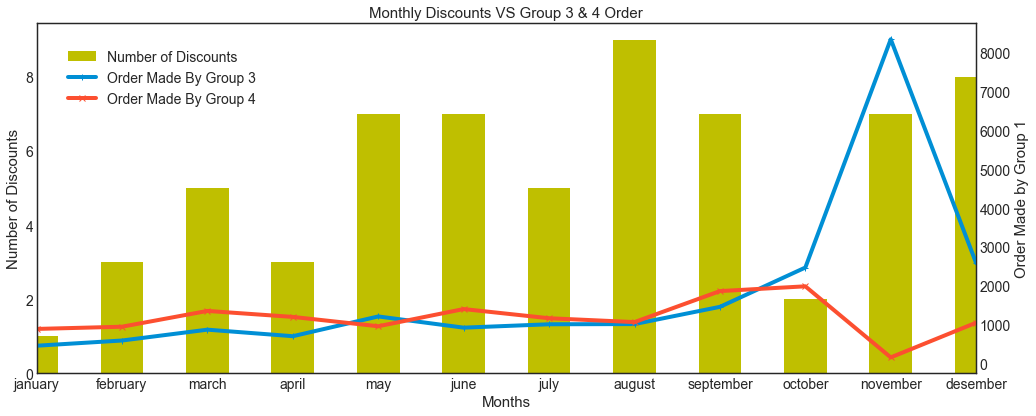

In [141]:
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1 = disc_ord['num_of_disc'].plot(kind='bar', color='y', label='Number of Discounts')
ax2 = disc_ord['Group 1'].plot(kind='line', marker='+', secondary_y=True, label = 'Order Made By Group 3')
ax3 = disc_ord['Group 2'].plot(kind='line', marker='x', secondary_y=True, label = 'Order Made By Group 4')


ax1.set_xlabel('Months',fontsize=15)
ax1.set_ylabel('Number of Discounts',fontsize=15)
ax2.set_ylabel('Order Made by Group 1',fontsize=15)
ax1.set_title('Monthly Discounts VS Group 3 & 4 Order',fontsize=15)
fig.legend(loc="upper left", bbox_to_anchor=(0.02,0.96), bbox_transform=ax1.transAxes)

#Saving Plot for dashboards
plt.savefig(r"C:\Users\HP.LAPTOP-5BTBEJFV\Documents\data science\MODULE 3\FINAL PROJECT\dashboard\static\monthly discounts 3&4.png", 
           bbox_inches='tight', dpi=150)
plt.show()

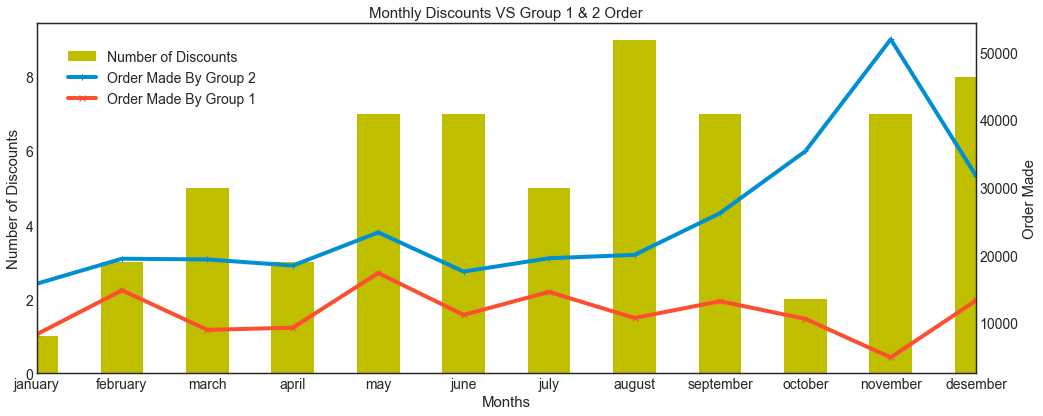

In [142]:
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1 = disc_ord['num_of_disc'].plot(kind='bar', color='y', label='Number of Discounts')
ax2 = disc_ord['Group 3'].plot(kind='line', marker='+', secondary_y=True, label = 'Order Made By Group 2')
ax3 = disc_ord['Group 4'].plot(kind='line', marker='x', secondary_y=True, label = 'Order Made By Group 1')


ax1.set_xlabel('Months',fontsize=15)
ax1.set_ylabel('Number of Discounts',fontsize=15)
ax2.set_ylabel('Order Made',fontsize=15)
ax1.set_title('Monthly Discounts VS Group 1 & 2 Order',fontsize=15)
fig.legend(loc="upper left", bbox_to_anchor=(0.02,0.96), bbox_transform=ax1.transAxes)

#Saving Plot for dashboards
plt.savefig(r"C:\Users\HP.LAPTOP-5BTBEJFV\Documents\data science\MODULE 3\FINAL PROJECT\dashboard\static\order made 1&2.png", 
           bbox_inches='tight', dpi=150)
plt.show()

#### 5. How does each cluster react on a discounts?

In [127]:
disc_corr = disc_ord.corr()
disc_corr = pd.DataFrame(disc_corr.drop('num_of_disc')['num_of_disc'])
disc_corr.sort_values(by='num_of_disc', ascending=False)

,num_of_disc
Group 1,0.271474
Group 3,0.234473
Group 4,0.178612
Group 2,-0.172953


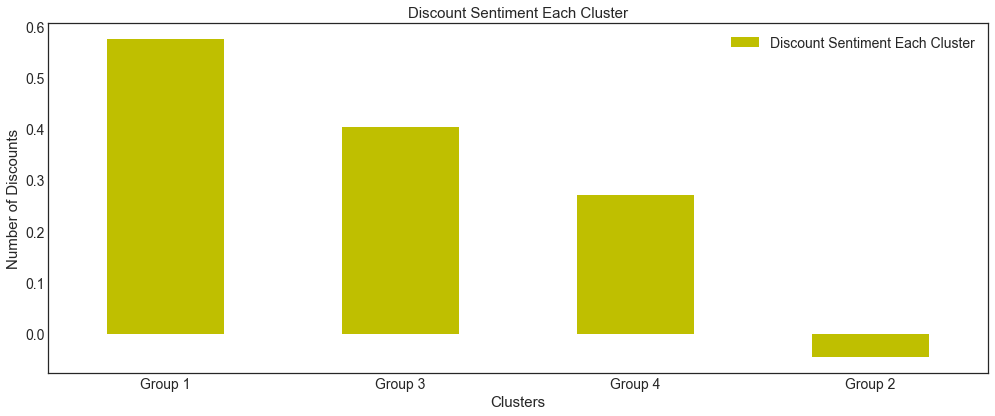

In [128]:
disc_corr = pd.DataFrame(disc_ord.corr('spearman')['num_of_disc'].sort_values(ascending=False))
disc_corr.drop(['num_of_disc'], inplace=True)

fig, ax1 = plt.subplots(figsize=(15, 6))
ax1 = disc_corr['num_of_disc'].plot(kind='bar', color='y', label='Discount Sentiment Each Cluster')
ax1.set_xlabel('Clusters',fontsize=15)
ax1.set_ylabel('Number of Discounts',fontsize=15)
ax2.set_ylabel('Order Made by Group 1',fontsize=15)
ax1.set_title('Discount Sentiment Each Cluster',fontsize=15)
plt.xticks(rotation=(0))
plt.legend()

#Saving Plot for dashboards
plt.savefig(r"C:\Users\HP.LAPTOP-5BTBEJFV\Documents\data science\MODULE 3\FINAL PROJECT\dashboard\static\discount sentiment.png", 
           bbox_inches='tight', dpi=150)
plt.show()